In [170]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

df_XAU_USD = pd.read_csv('NYU_XAU_USD_20142015_Spring2020.csv')
df_USD_JPY = pd.read_csv('NYU_USD_JPY_2016_Spring2020.csv')

def trade_ma(ma_short,ma_long,short,long):
    signal = [0]*long
    for i in range(long,len(ma_long)):
        #short cross long from above, sell
        if ma_short[i] < ma_long[i]:
            signal.append(-1)
        #short cross long from below, buy
        elif ma_short[i] > ma_long[i]:
            signal.append(1)
        else:
            signal.append(0)          
    return signal

def moving_avg(data,short,long):
    ma_long = data.Price.rolling(window=long).mean()
    ma_short = data.Price.rolling(window=short).mean()
    data['ma_short'] = ma_short
    data['ma_long'] = ma_long
    signal = trade_ma(ma_short,ma_long,short,long)
#     plt.figure(figsize=(15,8))
#     plt.plot(ma_short)
#     plt.plot(ma_long)
    data['signal'] = signal
    data['signal'] = data['signal'].shift(1)
    
    return data

def strategy_macd(data,short,long):
    data['long_ema'] = data['Price'].ewm(halflife=long).mean()
    data['short_ema'] = data['Price'].ewm(halflife=short).mean()
    data['MACD'] = (data['short_ema'] - data['long_ema'])
    data['macds'] = data['MACD'].ewm(halflife=9).mean()    
    signal = data['macds']  
    macd   = data['MACD']        
    listLongShort = [0]*long
    for i in range(long-1, len(signal)-1):
        # If the MACD crosses the signal line upward
        if macd[i] > signal[i] and macd[i - 1] <= signal[i - 1]:
            listLongShort.append(1)
        # The other way around
        elif macd[i] < signal[i] and macd[i - 1] >= signal[i - 1]:
            listLongShort.append(-1)
        # Do nothing if not crossed
        else:
            listLongShort.append(0)
    data['signal'] = listLongShort
    #data[['MACD','macds']].plot(grid=True,figsize=(8,5))
    #layback one hour
    return data

#We hold our long until we get the first bearish volume bar with increased volume. 
#for a proper exit signal, you want to see the volume increase relative to the last few candlesticks and the price to also go counter to the primary trend. This is an early indication that the impulsive move is in the process of at least slowing down, if not reversing.
def breakout_volume(data,mean_window,flow_window):
    #determine when to enter the market:
    #if the price cross the avg from below, entebr the market
    #exit: the first price that goes down with an volumn > avg volumn of 10 days
    rolling_mean = data.Price.rolling(window=mean_window).mean()
    rolling_avg_flow = data.Flow.rolling(window=flow_window).mean()
    signal = [0]*mean_window
    data['roll_avg'] = rolling_mean
    data['roll_flow'] = rolling_avg_flow
    for i in range(mean_window,len(data)):
        if data['Price'][i] > data['roll_avg'][i]:
            signal.append(1)
        #if the flow start to shink relatively to previous days
        elif data['Price'][i] < data['Price'][i-1] and data['Flow'][i] < data['roll_flow'][i]:
            signal.append(-1)
        else:
            signal.append(0)
            
    data['signal'] = signal
    data['signal'] = data['signal'].shift(1)
    return data

#Breakout + Volume Weighted Moving Average (VWMA)
def breakout_VWMA(data,mean_window):
    #calculate VWMA
    #create a column for price*volume
    data['price_flow'] = data['Price']*data['Flow']
    rolling_sum_price = data.price_flow.rolling(window=mean_window).sum()
    data['roll_price_sum'] = rolling_sum_price
    #create a column for rolling sum of the flow
    
    rolling_sum_flow = data.Flow.rolling(window=mean_window).sum()
    data['roll_flow_sum'] = rolling_sum_flow
    #calculate rolling VWMA
    data['VWMA'] = data['roll_price_sum']/ data['roll_flow_sum']
    
    signal = [0]*mean_window
    for i in range(mean_window,len(data)):
        if data['Price'][i] > data['VWMA'][i]:
            signal.append(1)
        elif data['Price'][i] < data['VWMA'][i-1]:
            signal.append(-1)
        else:
            signal.append(0)
            
    data['signal'] = signal
    data['signal'] = data['signal'].shift(1)
    
    return data

def back_test(data,capital,bos):
    portfolio_value = capital
    cash = capital
    position = 0
    pnl_list = []
    for i in range(len(data)):
        #first trade
        if position == 0:
            #long
            if data['signal'][i] == 1:
                position = np.floor(portfolio_value/(data['Price'][i]+(bos/2)))
                cash = portfolio_value - position * (data['Price'][i]+(bos/2))
            #short
            elif data['signal'][i] == -1:
                position = - np.floor(portfolio_value/(data['Price'][i]-(bos/2)))
                cash = portfolio_value - position * (data['Price'][i]-(bos/2))
        
        #long
        elif position < 0 and data['signal'][i] == 1:
            position = np.floor(portfolio_value/(data['Price'][i]+(bos/2)))
            cash = portfolio_value - position * (data['Price'][i]+(bos/2))
            
        #short
        elif position > 0 and data['signal'][i] == -1 :
            position = - np.floor(portfolio_value/(data['Price'][i]-(bos/2)))
            cash = portfolio_value - position * (data['Price'][i]-(bos/2))
                                                
        #portfolio value for each hour
        portfolio_value = cash + position * data['Price'][i]
        
        #flat at the end of day
        if (i-6) % 24==0:
            #print(data['Date'][i])
            pnl_list.append(portfolio_value - capital)
            portfolio_value = capital
            #if there is no trades, position = 0, cash = capital
            cash = capital
            position = 0
            
    
    pnl_ratio_list = [x/capital for x in pnl_list]
    #plt.plot(list(np.cumsum(pnl_ratio_list)))
    plt.plot(list(np.cumsum(pnl_ratio_list)))
    print(sum(pnl_ratio_list))
    
    return pnl_ratio_list


def maxDD(first):
    i = np.argmax(np.maximum.accumulate(first) - first) # end of the period
    j = np.argmax(first[:i]) # start of period

    plt.plot(first)
    plt.plot([i, j], [first[i], first[j]], 'o', color='Red', markersize=10)
    MaxDD = first[i]- first[j]
    print(MaxDD)
    return MaxDD

def sharpe_ratio(pnl_list, capital):
    #pnl ratio
    #a = [x/capital for x in pnl_list]
    #annulized sharpe ratio
    return np.mean(pnl_list)/np.std(pnl_list) * np.sqrt(252)


df_USD_JPY

0.17488096499999126


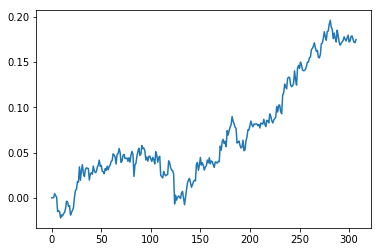

In [117]:
breakout_volume(df_USD_JPY,30,6)
pnl_list_breakout = back_test(df_USD_JPY,10000,0.0001)

In [118]:
sharpe_ratio(pnl_list_breakout,10000)

1.3894751220035741

-0.06546086000000177


-0.06546086000000177

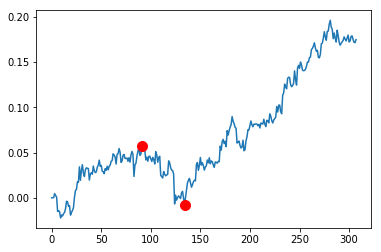

In [119]:
maxDD(np.cumsum(pnl_list_breakout))

0.11865647499999268


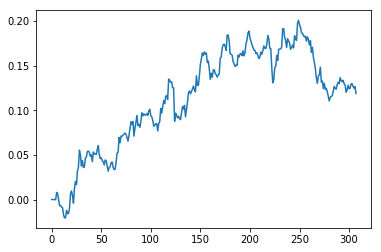

In [61]:
moving_avg(df_USD_JPY,10,100)
pnl_list_ma = back_test(df_USD_JPY,10000,0.0001)

In [62]:
sharpe_ratio(pnl_list_ma,10000)

0.8672871560905449

-0.09034023500000127


-0.09034023500000127

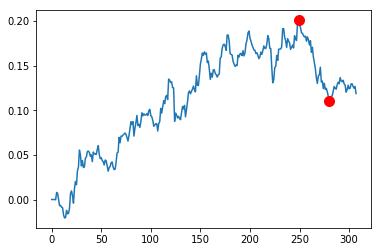

In [75]:
maxDD(np.cumsum(pnl_list_ma))

0.1487717949999909


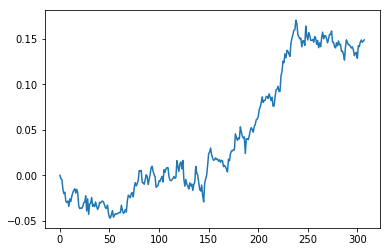

In [79]:
breakout_VWMA(df_USD_JPY,10)
pnl_list_VWMA = back_test(df_USD_JPY,10000,0.0001)

In [80]:
sharpe_ratio(pnl_list_VWMA,10000)

1.2093211163578894

-0.046773549999999706


-0.046773549999999706

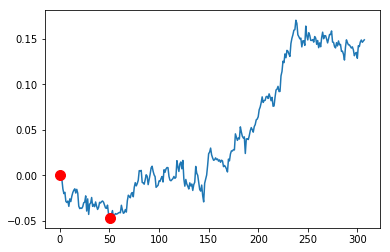

In [81]:
maxDD(np.cumsum(pnl_list_VWMA))

df_XAU_USD

0.17599750999997502


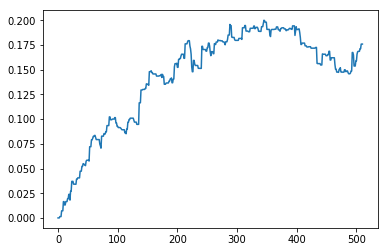

In [171]:
#12,26?
strategy_macd(df_XAU_USD,12,36)
pnl_list_macd = back_test(df_XAU_USD,10000,0.0001)

In [163]:
sharpe_ratio(pnl_list_macd,10000)

1.589023526350445

-0.042377940000004555


-0.042377940000004555

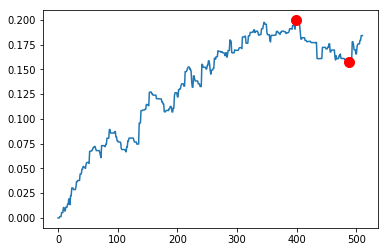

In [76]:
maxDD(np.cumsum(pnl_list_macd))

-0.2795476400002884


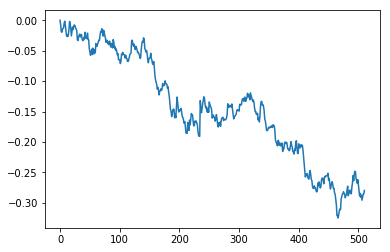

In [150]:
breakout_VWMA(df_XAU_USD,5)
pnl_list_breakout_gold = back_test(df_XAU_USD,10000,0.0001)

In [89]:
sharpe_ratio(pnl_list_breakout_gold,10000)

0.35863952478232325

-0.10405914000001956


-0.10405914000001956

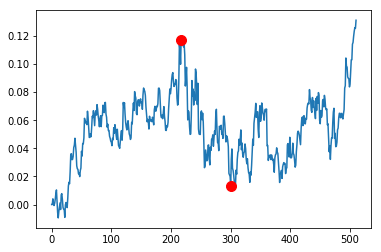

In [84]:
maxDD(np.cumsum(pnl_list_breakout_gold))

0.2080305249999467


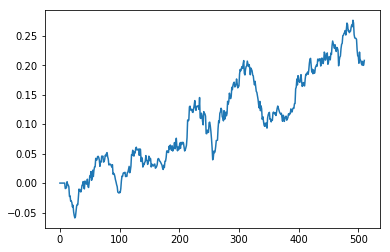

In [165]:
moving_avg(df_XAU_USD,20,200)
pnl_list_ma_gold = back_test(df_XAU_USD,10000,0.0001)

In [166]:
sharpe_ratio(pnl_list_ma_gold,10000)

0.819767213102221

-0.11454620000000504


-0.11454620000000504

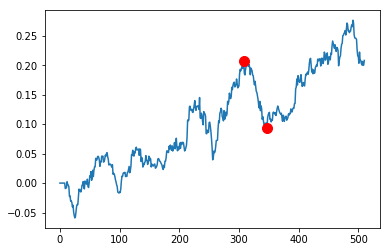

In [167]:
maxDD(np.cumsum(pnl_list_ma_gold))

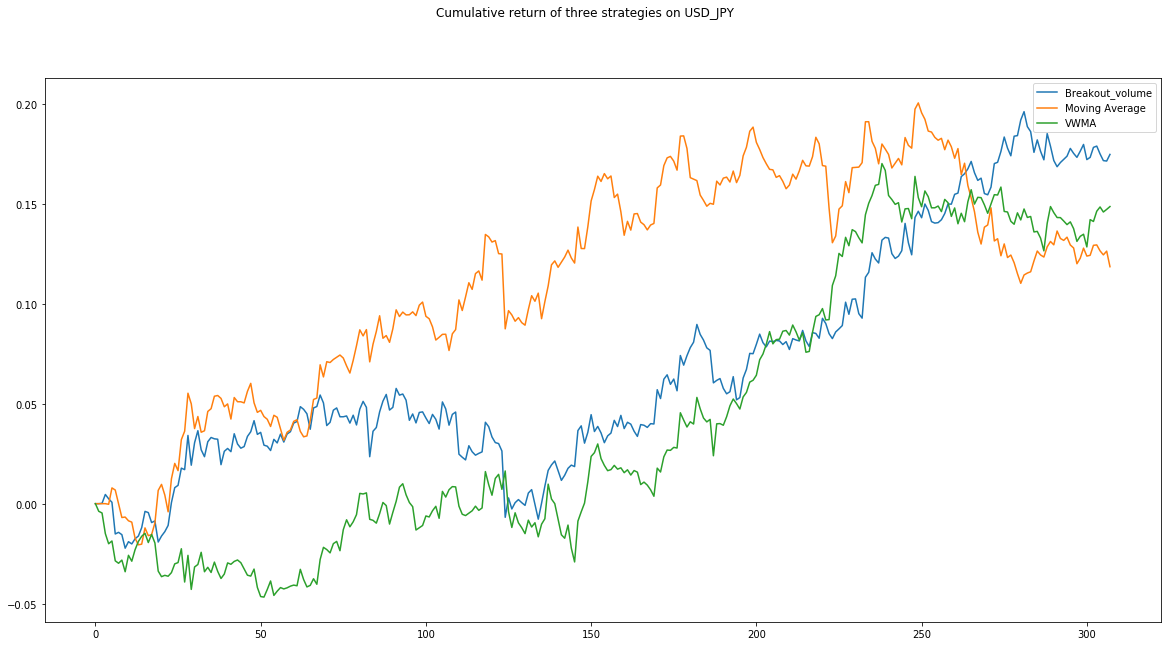

In [158]:
#jpy
fig = plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pnl_list_breakout),label = 'Breakout_volume')
plt.plot(np.cumsum(pnl_list_ma),label = 'Moving Average')
plt.plot(np.cumsum(pnl_list_VWMA),label = 'VWMA')
fig.suptitle('Cumulative return of three strategies on USD_JPY')
plt.legend()
plt.show()


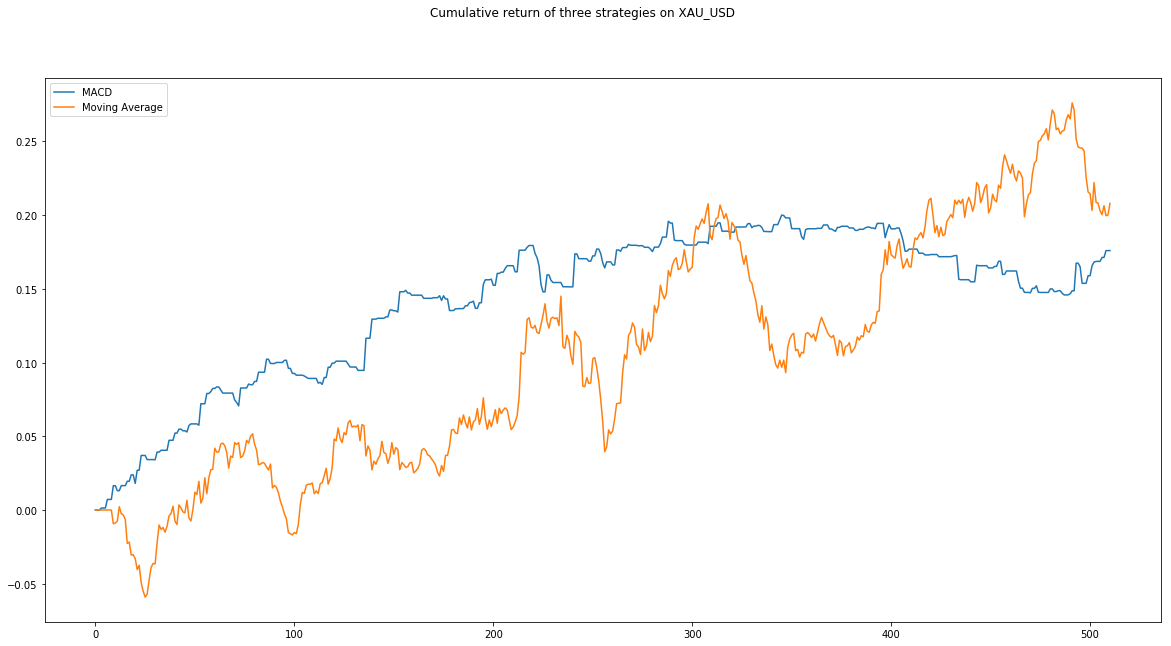

In [164]:
fig = plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pnl_list_macd),label = 'MACD')
plt.plot(np.cumsum(pnl_list_ma_gold),label = 'Moving Average')

fig.suptitle('Cumulative return of three strategies on XAU_USD ')
plt.legend()
plt.show()

-0.01624359360000037

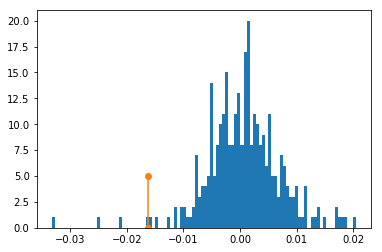

In [178]:
def CalculateVaR(pnl_list):
    pnl_ratio_list = pnl_list
    sorted_list = np.sort(pnl_ratio_list)
    var_level = 99
    var_99 = np.percentile(sorted_list, 100 - var_level)
    plt.figure()
    plt.hist(sorted_list, bins=100)
    var_x12, var_y12 = [var_99,var_99], [0, 5]
    plt.plot(var_x12, var_y12, marker = 'o')
    return var_99

CalculateVaR(pnl_list_breakout)
